In [26]:
import pandas as pd
import numpy as np

from sklearn.metrics.pairwise import pairwise_distances

#For plotting
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import datetime as dt
from pandas.plotting import scatter_matrix

from itertools import chain

In [28]:
# Load data from Steam Charts data file
data = pd.read_csv('SteamCharts.csv')

# Make percentile into number and clear "-"
data = data.replace(to_replace='%', value='', regex=True).replace({'-':'NaN'})#.replace(to_replace='Inf', value=+100, regex=True)
#data['Perc_Gain'] = data['Perc_Gain']/100

#data.head()

In [29]:
# Get Perc_Gain.
p_gain = data.loc[data['Perc_Gain']==1]
p_gain = p_gain.drop(columns=['Avg_Players', 'Gain', 'Perc_Gain', 'Peak_Players','Last 30 Days'])
p_gain_pure = p_gain.drop(columns=['App_id', 'Name']).astype(float)

# Get Avg_Players.
avg_players = data.loc[data['Avg_Players']==1]
avg_players = avg_players.drop(columns=['Avg_Players', 'Gain', 'Perc_Gain', 'Peak_Players','Last 30 Days'])
avg_pure = avg_players.drop(columns=['App_id', 'Name']).astype(float)

In [30]:
# Add columns of max and mean
avg_players['max'] = avg_pure.max(axis=1)
avg_players['mean'] = avg_pure.mean(axis=1)

In [ ]:
# Load data from Steam Spy data file. Download the csv file before you run this:
features = pd.read_csv('games-features-metacritic_ipload.csv')
features = features.drop_duplicates(subset=['ResponseID','ResponseName'], keep='first', inplace=False, ignore_index=False)
features = features.drop(columns=['QueryID', 'QueryName','RequiredAge'])
features = features.rename(columns={'ResponseID':'App_id','ResponseName':'Name'}, errors="raise")

# Combine data from Steam Charts and Steam Spy, order it by 'max' and save it as 'GamesDataNew.csv'
data = pd.merge(features, avg_players[['App_id','max','mean']], how='inner', on=['App_id'])
data = data.loc[data['GenreIsNonGame']==False]
data.sort_values(by=['max'], ascending=False, inplace=True)

data.reset_index(drop=True).to_csv('AllData.csv')

In [32]:
data = pd.read_csv('AllData.csv')
data.sample(5)

,Unnamed: 0,Unnamed: 0.1,App_id,Name,ReleaseDate,DemoCount,DeveloperCount,DLCCount,Metacritic,MovieCount,...,SupportedLanguages,Website,PCMinReqsText,PCRecReqsText,LinuxMinReqsText,LinuxRecReqsText,MacMinReqsText,MacRecReqsText,max,mean
5013,5013,48564,1252710,Cardaclysm,Feb 26 2021,0,1,1,0,2,...,English* Simplified Chinese French German Japa...,None,Minimum:OS: Windows 7 8 10Processor: 1.6 GHz D...,,,,,,20.08,8.181111
2587,2587,6020,359800,Copa Petrobras de Marcas,Apr 8 2015,0,1,0,0,1,...,English French Spanish Portuguese-Brazil,http://www.gamemarcas.com.br/index.php/en,Minimum:OS: Windows XP / Vista / 7 / 8Processo...,Recommended:OS: Windows 7Processor: 28 GHz Pen...,,,,,132.83,13.885068
398,398,8524,428690,Youtubers Life,May 18 2016,0,1,0,0,4,...,English Spanish German French Russian Traditio...,http://www.youtuberslife.com,Minimum:OS: Windows XPProcessor: Intel i3 or e...,,,,Minimum:OS: Mac OS X 10.8+Processor: 2 GHz or ...,,3006.16,283.101000
4396,4396,34583,1174460,Poker Club,Nov 20 2020,0,1,0,0,2,...,English* French Italian German Spanish - Spain...,http://pokerclubgame.com,Minimum:OS: Windows 10Processor: 2.0 GHz Dual ...,Recommended:OS: Windows 10Processor: 2.0 GHz D...,,,,,32.95,12.326667
6279,6279,1068,42230,Nancy Drew: Trail of the Twister,Jul 25 2011,0,1,0,-1,1,...,English,http://www.herinteractive.com/,OS: Windows(r) XP Vista or Windows 7Processor:...,,,,OS: OS X version Leopard 10.5.8 Snow Leopard 1...,,5.40,1.806038


In [33]:
#standard: a column name used to rank the games
#ranks: a list of rank cutoffs

def grade_analysis(ranks,standard='max', plot_cutoff=False,plot_figures=True,fig_size=(12,12)):
       
    grade = list(range(1,len(ranks)+1))
    a = np.array(ranks[1:]+[len(data)] ) - np.array( [0] + ranks[1:])
    grades = []
    for i in range(len(grade)):
        grades.append( [grade[i]]*a[i] )    
    grades = list(chain(*grades))
    
    # Sort data according to the 'standard'
    data_copy=data.copy()
    data_copy.sort_values(by=[standard], ascending=False, inplace=True)#.reset_index(drop=True)
    avg_graded = data_copy#.loc[data[standard]>=1].copy()

    # Rank the games
    if plot_cutoff:
        print('Using '+str(standard)+' :')
        for i in ranks:
            print('The cutoff for top '+str(i)+' games is '+str(avg_graded.reset_index(drop=True)[standard][i]))

    cutoffs = [0] + [avg_graded.reset_index(drop=True)[standard][i] for i in ranks[::-1]]
    #counts  = avg_graded[standard].value_counts(bins=cutoffs, sort=False,dropna=False) 
    #print(counts)

    #avg_graded = avg_players.loc[avg_players[standard]>=1].copy()
    avg_graded['Grade'] = grades

    data_clean = avg_graded[[#'ReleaseDate', 
        'CategorySinglePlayer',
       'CategoryMultiplayer', 
       'GenreIsIndie', 
                         'GenreIsAction', 
                         'GenreIsAdventure', 
                         'GenreIsCasual',
       'GenreIsStrategy', 
                         'GenreIsRPG', 
                         'GenreIsSimulation','Grade']]

#threshold = .2
#data_clean = data_clean.drop(data_clean.mean(axis=0)[data_clean.mean(axis=0) < threshold].index.values,axis=1)

    data_clean.columns = ['Single', 'Multi', 'Indie',
       'Action', 'Adventure', 'Casual', 'Strategy',
       'RPG', 'Simulation', 'Grade']

    data_test = {}
    for i in grade:
        data_test[i] = data_clean.loc[data_clean['Grade']==i].drop(columns=['Grade'])
        
    if plot_figures:
        plt.figure(figsize=fig_size)
        for i in grade:
            plt.plot(data_test[i].columns,data_test[i].mean(),label='Grade '+str(i))

        plt.legend()
        plt.title('By max of Avg_players')
        plt.show()
    return data_test

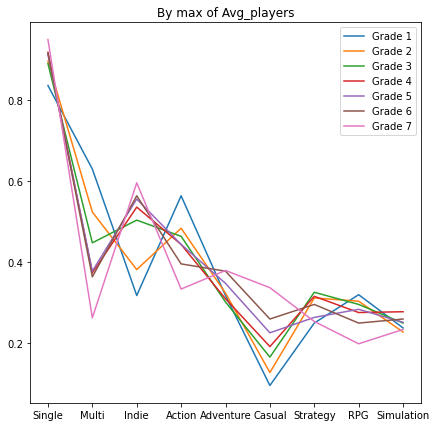

In [34]:
# We plot one figure given one ranking method here:
fig_size=(7,7)
ranks = list(np.arange(0,3500,500))
data_max = grade_analysis(ranks,standard='max', plot_cutoff=False,plot_figures=True,fig_size=fig_size)

In [35]:
# This function plots different methods together:
def grade_analysis_plot_all(methods,ranks,fig_size=(24,6)):
    fig,ax=plt.subplots(1,len(methods),figsize=fig_size)
    for j in range(len(methods)):
        data_copy = grade_analysis(ranks,standard= methods[j], plot_figures=False)
        for i in list(range(1,len(ranks)+1)):    
            ax[j].plot(data_copy[i].columns,data_copy[i].mean(),label='Grade '+str(i))
            ax[j].set_title('By '+str(methods[j]))
        ax[j].legend()
    plt.show()

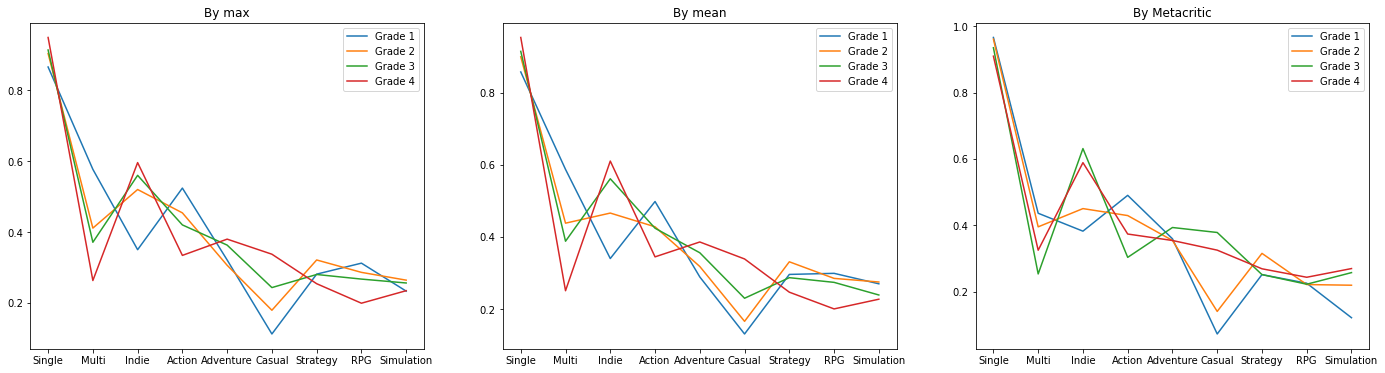

Rank cutoffs are [0, 1000, 2000, 3000]


In [36]:
methods = ['max','mean','Metacritic']
ranks = list(np.arange(0,3500,1000))
grade_analysis_plot_all(methods,ranks,fig_size=(24,6))
print('Rank cutoffs are '+str(ranks))

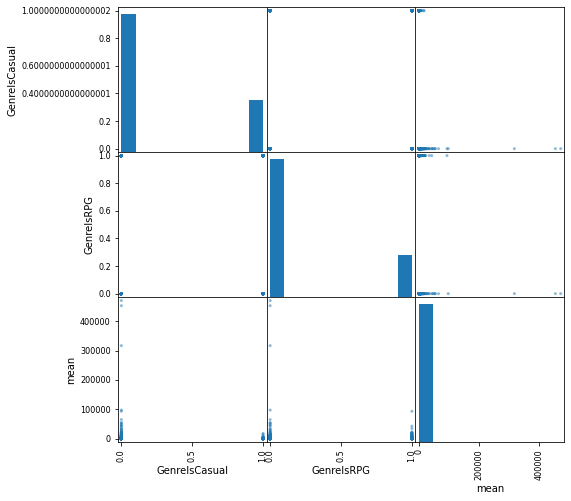

In [37]:
data_test = data[[ #'RecommendationCount',
        #'CategorySinglePlayer',
       #'CategoryMultiplayer', 
#       'GenreIsIndie', 
#                       'GenreIsAction', 
#                        'GenreIsAdventure', 
                        'GenreIsCasual',
#       'GenreIsStrategy', 
                         'GenreIsRPG', 
#                        'GenreIsSimulation', 
       #'PriceFinal',
                        'mean']].astype(float)

scatter_matrix(data_test,figsize=(8,8))
plt.show()

In [ ]:
data.mean()